<a href="https://colab.research.google.com/github/YuLiu83/Practical-business-case-code-demo/blob/main/Customer_Churn_and_Convert_Prediction_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn and Convert Prediction and Analysis
Prepared by Yu Liu

# High Level Contents:
#### Objective:
With the limited data from one of a world leading online steaming provider, conduct following two exercises:
    1. Predict the likelihood of customer conversion and recommend for business opportunities
    2. Predict likelihood of customer churning and recommend for business opportunities 

#### Part One: Data Preparation
    1. Load Necessary Python Libraries and Data (Three tables containing total 83 features and ~42 million rows)
    2. Data Exploration and Preparation
    
#### Part Two: Model Analysis
    1. Model 1: Customer Churn Prediction: Using Random Froest Model to predict likelihood of churning for customers
    2. Model 2: Survival Analysis - Importance of having customers starting their first show
    3. Model 3: Customer Conversion Prediction: Using Random Froest Model to predict likelihood of free trail conversion
    
#### Conclusion and Recommendation:
    1. Model 1 is able to successfully capture 93% churners based in the test data
    2. Model 2 reveals if the customer has not yet started their first streaming after 40 days, their likelihood of churning is 8% points more than the group of customers who have watched some programs
    3. Model 3 successfully recognizes 82% of the customers who did not convert to paid users in the test data
    4. Model 3 also reveals that users signed up from certain platforms are more likely to convert than users signed up from other platofrms    
    5. Marketing may design retention strategies targeting to identified potential churners and non-converters to increase their conversion and retention rate respectively
    6. Given limited time, there are more opportunities in the future that we can further improve our models

# Part One: Data Preparation

## 1. Load Library and Data:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, f1_score
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sksurv.nonparametric import kaplan_meier_estimator

In [ ]:
# Helper function
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Sign-up Info:
lifetime=pd.read_csv("C:****.csv", parse_dates=True)
# Media Info:
media=pd.read_csv("C:/****.csv",  parse_dates=True)
# Full Streaming Info:
Subscription_Raw=pd.read_csv("C:/****.csv",  parse_dates=True)
# Partial Streaming Info
Subscription=pd.read_csv("C:/****.csv",  parse_dates=True)

## 2. Data Exploration and Preparation:

### Lifetime Table:

In [ ]:
print(lifetime.shape)
lifetime.info()
lifetime.describe()
lifetime.head()

In [ ]:
#  Drop metrics not included in the modeling
# 'second_stream_minutes_watched' is removed due to (I believe) it's an error that it's 100% repeating 'first_stream_minutes_watched' col
lifetime.drop(['swid','sub_random','swid_random', 'sku', 'product_name','second_stream_minutes_watched','monthy_active_user_flag','monthly_minutes_watched','monthly_streams_watched','weekly_active_user_flag','weekly_minutes_watched','weekly_streams_watched','daily_active_user_flag','daily_minutes_watched','daily_streams_watched'], axis=1, inplace=True)
# some customers showing duplicated records, removing them for simplicity
Dup=lifetime[lifetime['subscription_source_ref'].duplicated()==True]['subscription_source_ref']
lifetime=lifetime[~lifetime['subscription_source_ref'].isin(Dup)]

In [ ]:
# Calculate Day Gap metrics Calculated for Modeling purposes:

lifetime['signup_date']=pd.to_datetime(lifetime['signup_date']).dt.date
lifetime['expiration_date']=pd.to_datetime(lifetime['expiration_date']).dt.date
lifetime['free_trial_conversion_date']=pd.to_datetime(lifetime['free_trial_conversion_date']).dt.date
lifetime['first_stream_date']=pd.to_datetime(lifetime['first_stream_date']).dt.date
lifetime['second_stream_date']=pd.to_datetime(lifetime['second_stream_date']).dt.date
lifetime['updated_as_of']=pd.to_datetime(lifetime['updated_as_of']).dt.date

lifetime['First_Two_Stream_Gap']=(lifetime['second_stream_date']-lifetime['first_stream_date']).dt.days
lifetime['First_Stream_Sign_Gap']=(lifetime['first_stream_date']-lifetime['signup_date']).dt.days

lifetime['Convert_Sign_Gap']=(lifetime['free_trial_conversion_date']-lifetime['signup_date']).dt.days  # the ones with larger gap tends to churn???
lifetime['First_Stream_Convert_Gap']=(lifetime['free_trial_conversion_date']-lifetime['first_stream_date']).dt.days # +/-
lifetime['Second_Stream_Convert_Gap']=(lifetime['free_trial_conversion_date']-lifetime['second_stream_date']).dt.days # +/-，

lifetime.loc[lifetime['expiration_date']>=lifetime['updated_as_of'] ,'Customer_Day']=(lifetime['updated_as_of']-lifetime['signup_date']).dt.days
lifetime.loc[lifetime['expiration_date']<lifetime['updated_as_of'] ,'Customer_Day']=(lifetime['expiration_date']-lifetime['signup_date']).dt.days

lifetime.loc[lifetime['expiration_date']>=lifetime['updated_as_of'] ,'Convert_Exp_or_update_Gap']=(lifetime['updated_as_of']-lifetime['free_trial_conversion_date']).dt.days
lifetime.loc[lifetime['expiration_date']<lifetime['updated_as_of'] ,'Convert_Exp_or_update_Gap']=(lifetime['expiration_date']-lifetime['free_trial_conversion_date']).dt.days

lifetime.loc[lifetime['expiration_date']>=lifetime['updated_as_of'] ,'Second_Stream_Exp_or_update_Gap']=(lifetime['updated_as_of']-lifetime['second_stream_date']).dt.days
lifetime.loc[lifetime['expiration_date']<lifetime['updated_as_of'] ,'Second_Stream_Exp_or_update_Gap']=(lifetime['expiration_date']-lifetime['second_stream_date']).dt.days

In [ ]:
# Calculate Average usages upto data pull date: Data already contains 'average_minutes_watched' - min watched per active day
# for active days
lifetime.loc[lifetime['days_active']!=0,'Avg_Streams_Watched_Active_Day']=lifetime['total_streams_watched']/lifetime['days_active']
lifetime.loc[lifetime['days_active']==0,'Avg_Streams_Watched_Active_Day']=0
lifetime.loc[lifetime['days_active']!=0,'Avg_Streams_Started_Active_Day']=lifetime['total_streams_started']/lifetime['days_active']
lifetime.loc[lifetime['days_active']==0,'Avg_Streams_Started_Active_Day']=0

# for tenure
lifetime['Avg_Streams_Watched_Customer_Day']=lifetime['total_streams_watched']/lifetime['Customer_Day']
lifetime['Avg_Streams_Started_Customer_Day']=lifetime['total_streams_started']/lifetime['Customer_Day']
lifetime['Avg_Min_Watched_Customer_Day']=lifetime['total_minutes_watched']/lifetime['Customer_Day']

In [ ]:
# Flags for If a customer had the 1st stream, if a customer had the 2nd stream
lifetime.loc[lifetime['first_stream_media_id'].notnull(),'Had_First_Show']=1
lifetime.loc[lifetime['first_stream_media_id'].isnull(),'Had_First_Show']=0

lifetime.loc[lifetime['second_stream_media_id'].notnull(),'Had_Second_Show']=1
lifetime.loc[lifetime['second_stream_media_id'].isnull(),'Had_Second_Show']=0

### Media Table:

In [ ]:
print(media.shape)
media.info()
media.describe()
media.head()

In [ ]:
#  Drop metrics not included in the modeling
media.drop(['livebroadcast','contentsource','type','league','hometeamname', 'awayteamname','contentid','partnerairingid','channel_id','mediaconfig_state','title','shorttitle','descriptionlong','descriptionshort','titleepisodename','hometeamid','awayteamid','gamedescription','teams'],axis=1, inplace=True)

In [ ]:
# Re-code 'Ice Hockey' to 'Hockey'
media['sport'].unique()
media.loc[media['sport']=='Ice Hockey', 'sport']='Hockey'

### Subscription Table:

In [ ]:
print(Subscription.shape)
Subscription.info()
Subscription.describe()
Subscription.head()

In [ ]:
#  Drop metrics not included in the modeling
Subscription.drop(['sku','platform','total_streams_started','total_streams_watched','total_minutes_watched','average_minutes_watched','monthly_active_user_flag','weekly_active_user_flag','daily_active_user_flag','primary_viewing_device_to_date'],axis=1, inplace=True)
Subscription.drop(['Unnamed: 0'],axis=1, inplace=True)

In [ ]:
# Calculate Average usages upto each day
# for per active day
Subscription.loc[Subscription['days_watched_to_date']!=0,'Avg_Stm_Wched_Active_Day']=Subscription['streams_watched_to_date']/Subscription['days_watched_to_date']
Subscription.loc[Subscription['days_watched_to_date']==0,'Avg_Stm_Wched_Active_Day']=0

Subscription.loc[Subscription['days_watched_to_date']!=0,'Avg_Stm_Staed_Active_Day']=Subscription['streams_started_to_date']/Subscription['days_watched_to_date']
Subscription.loc[Subscription['days_watched_to_date']==0,'Avg_Stm_Staed_Active_Day']=0

Subscription.loc[Subscription['days_watched_to_date']!=0,'Avg_Mins_Watched_Active_Day']=Subscription['mins_watched_to_date']/Subscription['days_watched_to_date']
Subscription.loc[Subscription['days_watched_to_date']==0,'Avg_Mins_Watched_Active_Day']=0

# for per subscribe day
Subscription['Avg_Stm_Wched_Subscribe_Day']=Subscription['streams_watched_to_date']/Subscription['days_subscribed']
Subscription['Avg_Stm_Staed_Subscribe_Day']=Subscription['streams_started_to_date']/Subscription['days_subscribed']
Subscription['Avg_Mins_Watched_Subscribe_Day']=Subscription['mins_watched_to_date']/Subscription['days_subscribed']

Subscription['subscription_day']=pd.to_datetime(Subscription['subscription_day']).dt.date


### Append media details for customer streamings listed in the Lifetime Table:

In [ ]:
# Adding informaiton for the 1st streaming:
lifetime_1stwatch_media=pd.merge(lifetime, media, how='left', left_on='first_stream_media_id', right_on='mediaid')
lifetime_1stwatch_media.rename(columns={'gamedate_est':'FS_gamedate_est','runtime':'FS_Runtime', 'sport':'FS_Sport', 'programtype':'FS_Program_Type', 'mediaconfig_producttype':'FS_mediaconfig_producttype','hometeamname':'FS_Hometeamname', 'awayteamname':'FS_Awayteamname'}, inplace=True)
lifetime_1stwatch_media.drop('mediaid',axis=1, inplace=True)

In [ ]:
# Adding informaiton for the 2nd streaming:
lifetime_media=pd.merge(lifetime_1stwatch_media, media, left_on='second_stream_media_id', right_on='mediaid', how='left')
lifetime_media.rename(columns={'gamedate_est':'SD_gamedate_est','runtime':'SD_Runtime', 'sport':'SD_Sport', 'programtype':'SD_Program_Type', 'mediaconfig_producttype':'SD_mediaconfig_producttype','hometeamname':'SD_Hometeamname', 'awayteamname':'SD_Awayteamname'}, inplace=True)
lifetime_media.drop('mediaid',axis=1, inplace=True)

In [ ]:
# Calculate Runtime in minutes:
lifetime_media.loc[lifetime_media['FS_Runtime'].isnull(), 'FS_Runtime']='00:00:00'
lifetime_media.loc[lifetime_media['SD_Runtime'].isnull(), 'SD_Runtime']='00:00:00'
lifetime_media['FS_Runtime_Min']=lifetime_media['FS_Runtime'].str.split(':').apply(lambda x: int(x[0])*60+int(x[1]))
lifetime_media['SD_Runtime_Min']=lifetime_media['SD_Runtime'].str.split(':').apply(lambda x: int(x[0])*60+int(x[1]))

In [ ]:
# Calculate % of first shows were finished
lifetime_media.loc[lifetime_media['FS_Runtime_Min']!=0, 'FS_Finish_Rate']=lifetime_media['first_stream_minutes_watched']/lifetime_media['FS_Runtime_Min']
# % of second show finished is not calculated, due to its suspected error of replicating the first show watch time


In [ ]:
# Treatment on missing values:
lifetime_media.loc[lifetime_media['FS_Program_Type'].isnull(),'FS_Program_Type']='Unknown'
lifetime_media.loc[(lifetime_media['SD_Program_Type'].isnull()) & (lifetime_media['Had_Second_Show']==1),'SD_Program_Type']='Unknown'
lifetime_media.loc[(lifetime_media['SD_Program_Type'].isnull()) & (lifetime_media['Had_Second_Show']==0),'SD_Program_Type']='None'

lifetime_media.loc[lifetime_media['FS_Sport'].isnull(),'FS_Sport']='Unknown'
lifetime_media.loc[(lifetime_media['SD_Sport'].isnull()) & (lifetime_media['Had_Second_Show']==1),'SD_Sport']='Unknown'
lifetime_media.loc[(lifetime_media['SD_Sport'].isnull()) & (lifetime_media['Had_Second_Show']==0),'SD_Sport']='None'

lifetime_media.loc[lifetime_media['FS_mediaconfig_producttype'].isnull(),'FS_mediaconfig_producttype']='Unknown'
lifetime_media.loc[(lifetime_media['SD_mediaconfig_producttype'].isnull()) & (lifetime_media['Had_Second_Show']==1),'SD_mediaconfig_producttype']='Unknown'
lifetime_media.loc[(lifetime_media['SD_mediaconfig_producttype'].isnull()) & (lifetime_media['Had_Second_Show']==0),'SD_mediaconfig_producttype']='None'


lifetime_media.loc[lifetime_media['First_Two_Stream_Gap'].isnull(),'First_Two_Stream_Gap']=200
lifetime_media.loc[lifetime_media['Second_Stream_Convert_Gap'].isnull(),'Second_Stream_Convert_Gap']=200
lifetime_media.loc[lifetime_media['Second_Stream_Exp_or_update_Gap'].isnull(),'Second_Stream_Exp_or_update_Gap']=200
lifetime_media.loc[lifetime_media['FS_Finish_Rate'].isnull(),'FS_Finish_Rate']=200

# Part Two: Model Analysis

## Model 1: Customer Churn Prediction: Using Random Froest Model to predict likelihood of churning for customers:
1. Non-free-trial
2. Watched at least one show

### Select data for churn prediction:

In [ ]:
# exclude customers who never watched any shows before pull date:
# select customers with only 7 days' free trial
# if no conversion date, not paid customers
Viewer_Churn=lifetime_media[lifetime_media['total_streams_started']!=0]
Viewer_Churn=Viewer_Churn[Viewer_Churn['free_trial_length']==7]
Viewer_Churn=Viewer_Churn[(Viewer_Churn['free_trial_conversion_date'].notnull()) & (Viewer_Churn['expiration_date']>Viewer_Churn['free_trial_conversion_date'])]

In [ ]:
# Exclude non-needed features:
Viewer_Churn.drop(['subscription_source_ref', 'signup_date','expiration_date','free_trial_conversion_date',
                   'converted_to_paid','free_trial_flag', 'free_trial_length','is_in_free_trial_flag','active_paid_flag'
                   ,'trial_abandon_flag','is_active' , 'first_stream_media_id','second_stream_media_id',
                   'first_stream_date','second_stream_date', 'updated_as_of', 'converted_to_paid', 'FS_gamedate_est', 'SD_gamedate_est'], axis=1, inplace=True)

In [ ]:
# Feature Encoding:
Viewer_Churn_Encoded=pd.get_dummies(Viewer_Churn)
Viewer_Churn_Encoded.shape

(123752, 160)

In [ ]:
# Prep training / testing tables: 65%: 35%
target=Viewer_Churn_Encoded['paid_churn_flag']
features=Viewer_Churn_Encoded.drop(['paid_churn_flag'], axis=1)

x_train,x_test,y_train,y_test = train_test_split(features,target, stratify=target,test_size=0.35, random_state=1)

In [ ]:
y_test_leg = y_test.value_counts()[0]
y_test_fra = y_test.value_counts()[1]

### Grid Search and Model Fitting:

In [ ]:
# Grid Search for hyper-parameters, for simplicity we only searched on tree depth-'max_depth'

forest = RandomForestClassifier(n_estimators=50, random_state=2)
param_grid={'max_depth':np.arange(14,20)}

tree_CV=GridSearchCV(forest, param_grid, scoring='f1', cv=5) # RandomizedSearchCV() can be faster when lots of Grid options
tree_CV.fit(x_train, y_train)

print(tree_CV.best_params_)
print(tree_CV.best_score_)


{'max_depth': 18}
0.952503428342717


In [ ]:
forest_model = RandomForestClassifier(n_estimators=50, random_state=2, max_depth=3)
forest_model_fitted=forest_model.fit(x_train, y_train)
forest_predict=forest_model.predict(x_test)

In [ ]:
#Feature importances - top Five influential features:
score=forest_model_fitted.feature_importances_
name=list(Viewer_Churn_Encoded)
name_array=np.asarray(name)
combine=pd.DataFrame([name_array, score]).T
combine.columns=('Name', 'Score')

print(combine.sort_values('Score', ascending=0).head())

                                Name      Score
12                      Customer_Day   0.327954
11         Second_Stream_Convert_Gap   0.251774
13         Convert_Exp_or_update_Gap   0.143893
16    Avg_Streams_Started_Active_Day  0.0577552
17  Avg_Streams_Watched_Customer_Day  0.0332407


In [ ]:
# peek on a sampled tree
estimator = forest_model.estimators_[28] # tree #28
target=y_test.astype(str).unique()

#output the graph spec into a dot file
from sklearn.tree import export_graphviz
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(x_test.columns),
                class_names = target,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [ ]:
# Windows command to change the format from .dot to .png
!dot -Tpng tree.dot -o tree.png -Gdpi=600 -T svg

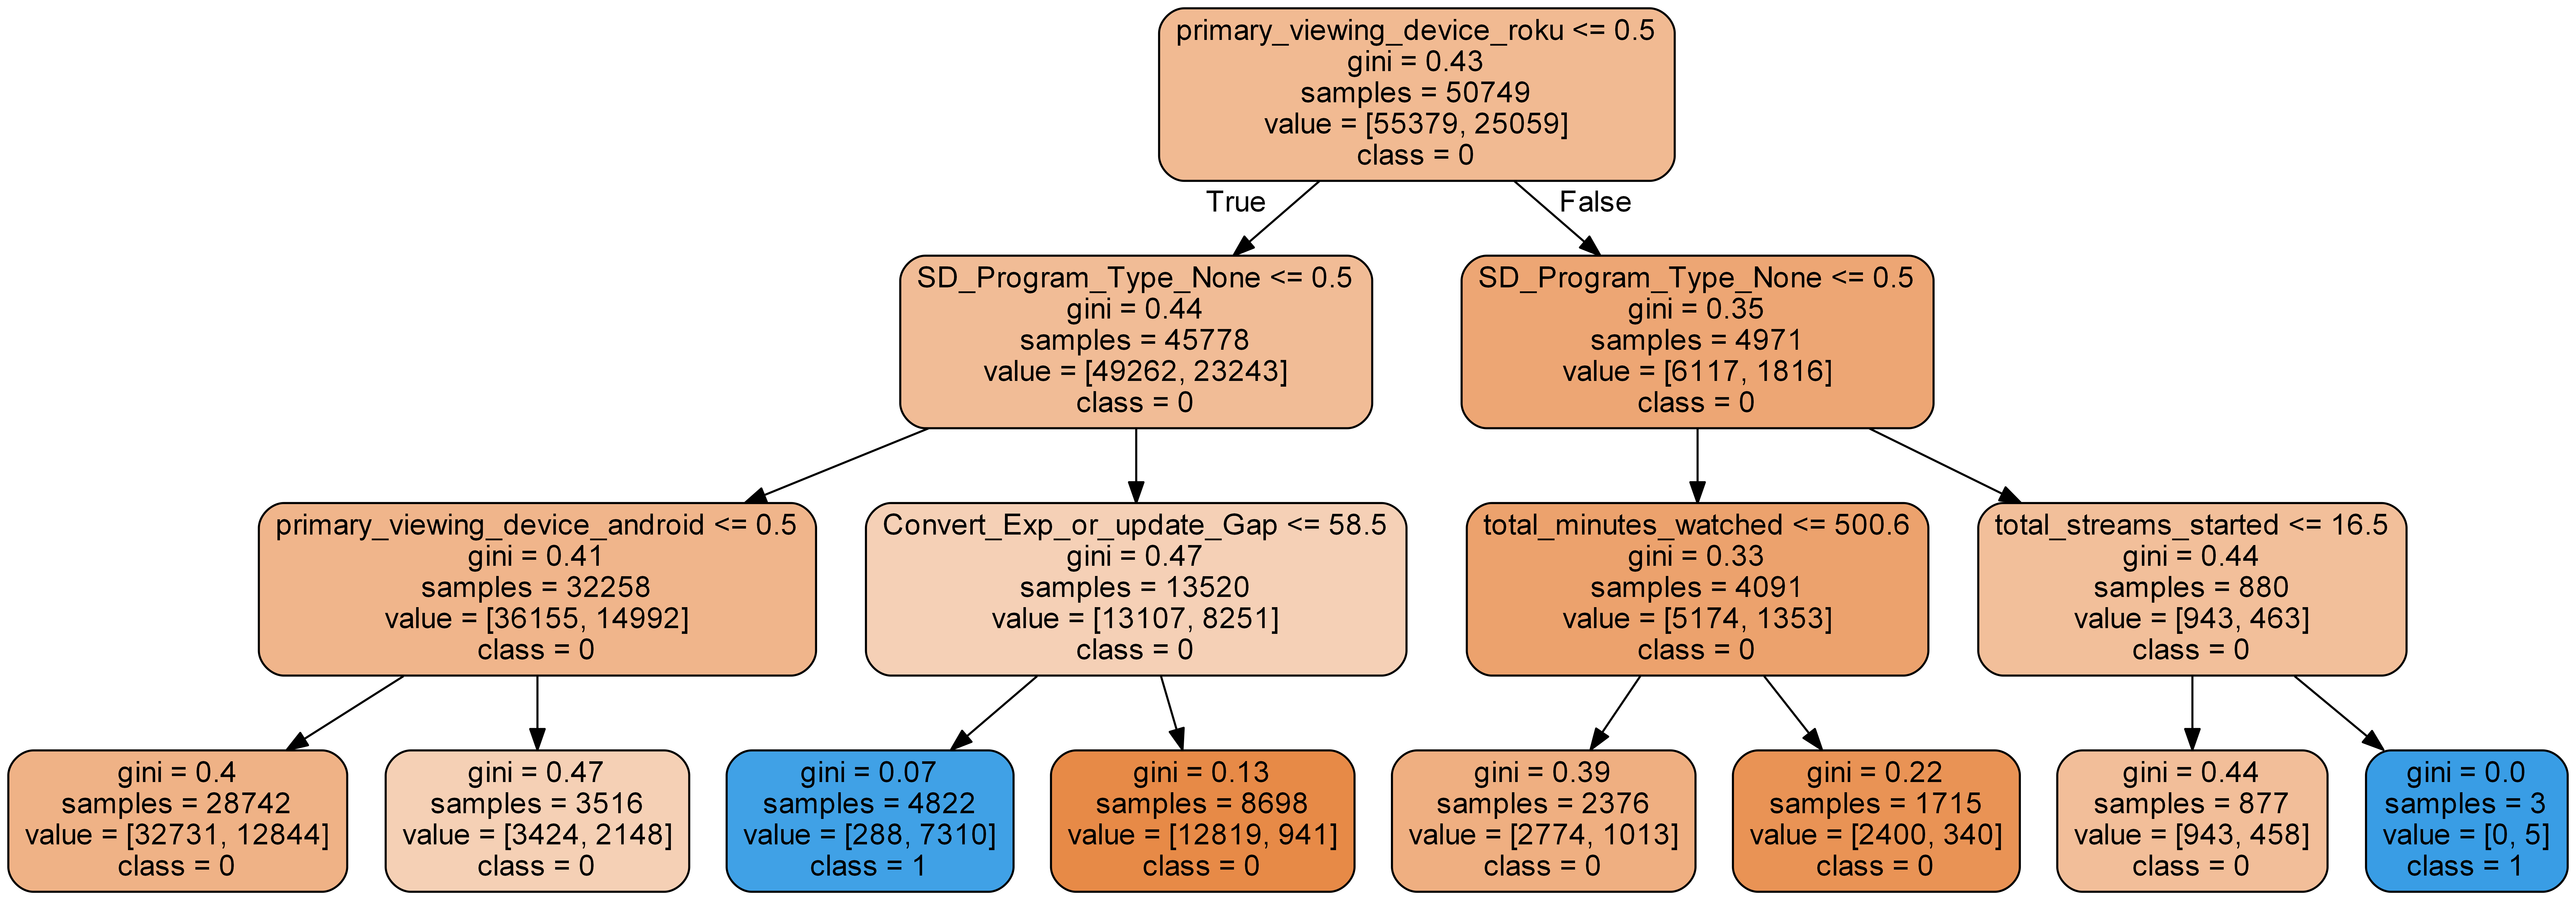

In [ ]:
# draw the tree
from IPython.display import Image
Image(filename = 'tree.png')

### Model Diagnostic:

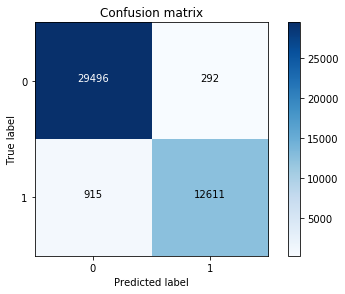

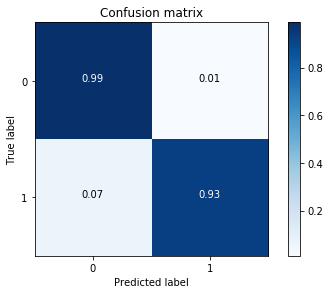

In [ ]:
# Confusion Matrix:
confusion= confusion_matrix(y_test, forest_predict)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(confusion, normalize=False , classes=class_names, title='Confusion matrix')
plt.show()
# Build normalization matrix using the counts in test data for each category
norm_matrix=np.array([[1/y_test_leg, 1/y_test_leg], [1/y_test_fra, 1/y_test_fra]])
# normalize the unbalanced regular confusion matrix， each row sums up to 1
confusion_norm = np.around(confusion*norm_matrix, 2)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(confusion_norm, normalize=False , classes=class_names, title='Confusion matrix')
plt.show()

In [ ]:
# Classificatoin report of the test data
print("Classification report with training data")
print(classification_report(y_test, forest_predict))

Classification report with training data
             precision    recall  f1-score   support

          0       0.97      0.99      0.98     29788
          1       0.98      0.93      0.95     13526

avg / total       0.97      0.97      0.97     43314



Average Precision:
0.9894039382807567


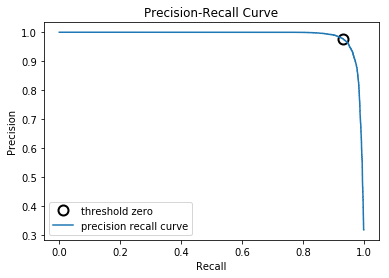

In [ ]:
precision, recall, thresholds=precision_recall_curve(y_test, forest_model.predict_proba(x_test)[:,1])


# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds-0.5))

plt.plot( recall[close_zero],precision[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(recall, precision, label="precision recall curve")

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best")
plt.title('Precision-Recall Curve')
Average_Precision=average_precision_score(y_test, forest_model.predict_proba(x_test)[:,1])
print("Average Precision:\n{}".format(Average_Precision));


AUC score:
0.992623177269204


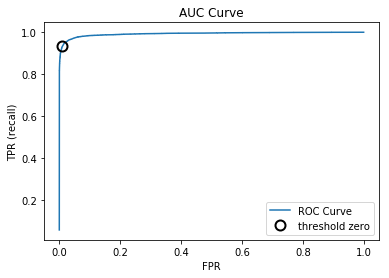

In [ ]:
# AUC curve and Score
fpr, tpr, thresholds = roc_curve(y_test, forest_model.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds-0.5))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.title('AUC Curve')
auc=roc_auc_score(y_test,  forest_model.predict_proba(x_test)[:,1])
print("AUC score:\n{}".format(auc))

Text(0, 0.5, 'True probability with Test data')

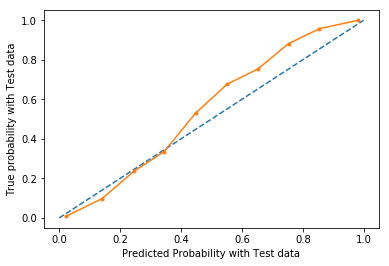

In [ ]:
# Test set predicted probabily
probs=forest_model_fitted.predict_proba(x_test)[:,1] # Probility Estimate
prob_true, prob_pred=calibration_curve(y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(prob_pred, prob_true, marker='.')
plt.xlabel("Predicted Probability with Test data")
plt.ylabel("True probability with Test data")

### Conclusion and Recommendation:
1. Random Forest model is able to successfully capture 93% churners in the test data
2. 0.95 F1 score suggests a balance between Precision and Recall
2. Precision-recall curve, ROC Curve and Calibration charts all showing strong performance of the model
3. Using 0.5 as the cut-off decision boundary for potential churners appears valid

## Model 2: Survival Analysis - Importance of having customers starting their first show

In [ ]:
Survival=lifetime_media[lifetime_media['free_trial_length']==7]
Survival=Survival[(Survival['free_trial_conversion_date'].notnull()) & (Survival['expiration_date']>Survival['free_trial_conversion_date'])]
Survival.loc[Survival['total_streams_started']!=0, 'Show_Watched']='Any Watch'
Survival.loc[Survival['total_streams_started']==0, 'Show_Watched']='No Watch'
Survival=Survival[['paid_churn_flag','Customer_Day', 'Show_Watched']]
Survival.loc[Survival['paid_churn_flag']==1, 'paid_churn_flag']=True
Survival.loc[Survival['paid_churn_flag']==0, 'paid_churn_flag']=False

Survival_C=Survival[['Show_Watched']]
Survival_S=Survival[['paid_churn_flag', 'Customer_Day']].to_records(index=False)


Text(0.5, 1.0, 'Churn Likeihood vs Tenure')

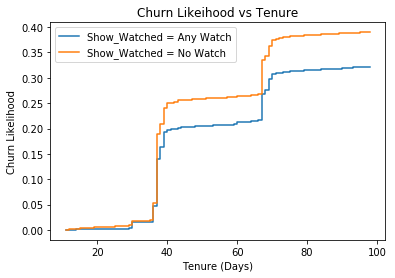

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
for group in ("Any Watch", "No Watch"):
    mask = Survival_C["Show_Watched"] == group
    time, surv_prob = kaplan_meier_estimator(
        Survival_S["paid_churn_flag"][mask],
        Survival_S["Customer_Day"][mask])
    plt.step(time, 1-surv_prob, label="Show_Watched = {}".format(group))
    plt.legend()

plt.xlabel("Tenure (Days)")
plt.ylabel("Churn Likelihood")
plt.title("Churn Likeihood vs Tenure")

#likelihood of churning is much higher for customers didn't watch any show after 39 days.

### Conclusion and Recommendation: 
1. Graph shows the longer the customer with us, the more likely they are churning
2. If the customer has not yet started their first streaming after 40 days, their likelihood of churning is 8% points more than the group of customers who have watched some programs
3. Marketing may design retention strategies to encourage customers starting their first streamings in the first month of their subscription

## Model 3: Customer Conversion Prediction: Using Random Froest Model to predict likelihood of free trail conversion:

### Data preparation and selection for conversion likelihood prediction:

In [ ]:
# Add cumulative streaming stats upto end of 7 days' free trial

lifetime_media['Free_Trial_End']=(lifetime_media['signup_date']+pd.DateOffset(days=7)).dt.date
lifetime_media_Sub=pd.merge(lifetime_media, Subscription, how='inner', left_on=['subscription_source_ref','Free_Trial_End'], right_on=['subscription_source_ref','subscription_day'])

In [ ]:
# Select properate metrics for fitting the model

Customer_Convert=lifetime_media_Sub[['platform', 'cohort', 'converted_to_paid',
        'days_watched_to_date', 'streams_started_to_date',
       'streams_watched_to_date', 'mins_watched_to_date',
       'Avg_Mins_Watched_Active_Day', 'Avg_Mins_Watched_Subscribe_Day',
       'Avg_Stm_Wched_Active_Day', 'Avg_Stm_Staed_Active_Day',
       'Avg_Stm_Wched_Subscribe_Day', 'Avg_Stm_Staed_Subscribe_Day']]

In [ ]:
# Feature Encoding and training/ testing splits: 65%: 35%
Customer_Convert_Encoded=pd.get_dummies(Customer_Convert)

target=Customer_Convert_Encoded['converted_to_paid']
features=Customer_Convert_Encoded.drop(['converted_to_paid'], axis=1)

x_train,x_test,y_train,y_test = train_test_split(features,target, stratify=target,test_size=0.35, random_state=1)

In [ ]:
y_test_leg = y_test.value_counts()[0]
y_test_fra = y_test.value_counts()[1]

### Grid Search and Model Fitting:

In [ ]:
# Grid Search for hyper-parameters, for simplicity we only searched on tree depth-'max_depth'
forest = RandomForestClassifier(n_estimators=50, random_state=2, class_weight='balanced')
param_grid={'max_depth':np.arange(3,8)}

tree_CV=GridSearchCV(forest, param_grid, scoring='f1', cv=5) # RandomizedSearchCV() can be faster when lots of Grid options
tree_CV.fit(x_train, y_train)

print(tree_CV.best_params_)
print(tree_CV.best_score_)


{'max_depth': 4}
0.7182677255178109


In [ ]:
forest_model = RandomForestClassifier(n_estimators=50, random_state=2, max_depth=3, class_weight='balanced')
forest_model_fitted=forest_model.fit(x_train, y_train)
forest_predict=forest_model.predict(x_test)

In [ ]:
#Feature importances - top Five influential features:
score=forest_model_fitted.feature_importances_
name=list(Customer_Convert_Encoded)
name_array=np.asarray(name)
combine=pd.DataFrame([name_array, score]).T
combine.columns=('Name', 'Score')

print(combine.sort_values('Score', ascending=0).head())

                           Name      Score
12               platform_APPLE   0.482989
11              platform_AMAZON   0.236316
13             platform_BAMTECH  0.0592654
5   Avg_Mins_Watched_Active_Day  0.0517215
3       streams_watched_to_date  0.0509074


In [ ]:
# peek on a sampled tree
estimator = forest_model.estimators_[28] # tree #28
target=y_test.astype(str).unique()
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(x_test.columns),
                class_names = target,
                rounded = True, proportion = False, 
                precision = 2, filled = True)
!dot -Tpng tree.dot -o tree.png -Gdpi=600 -T svg

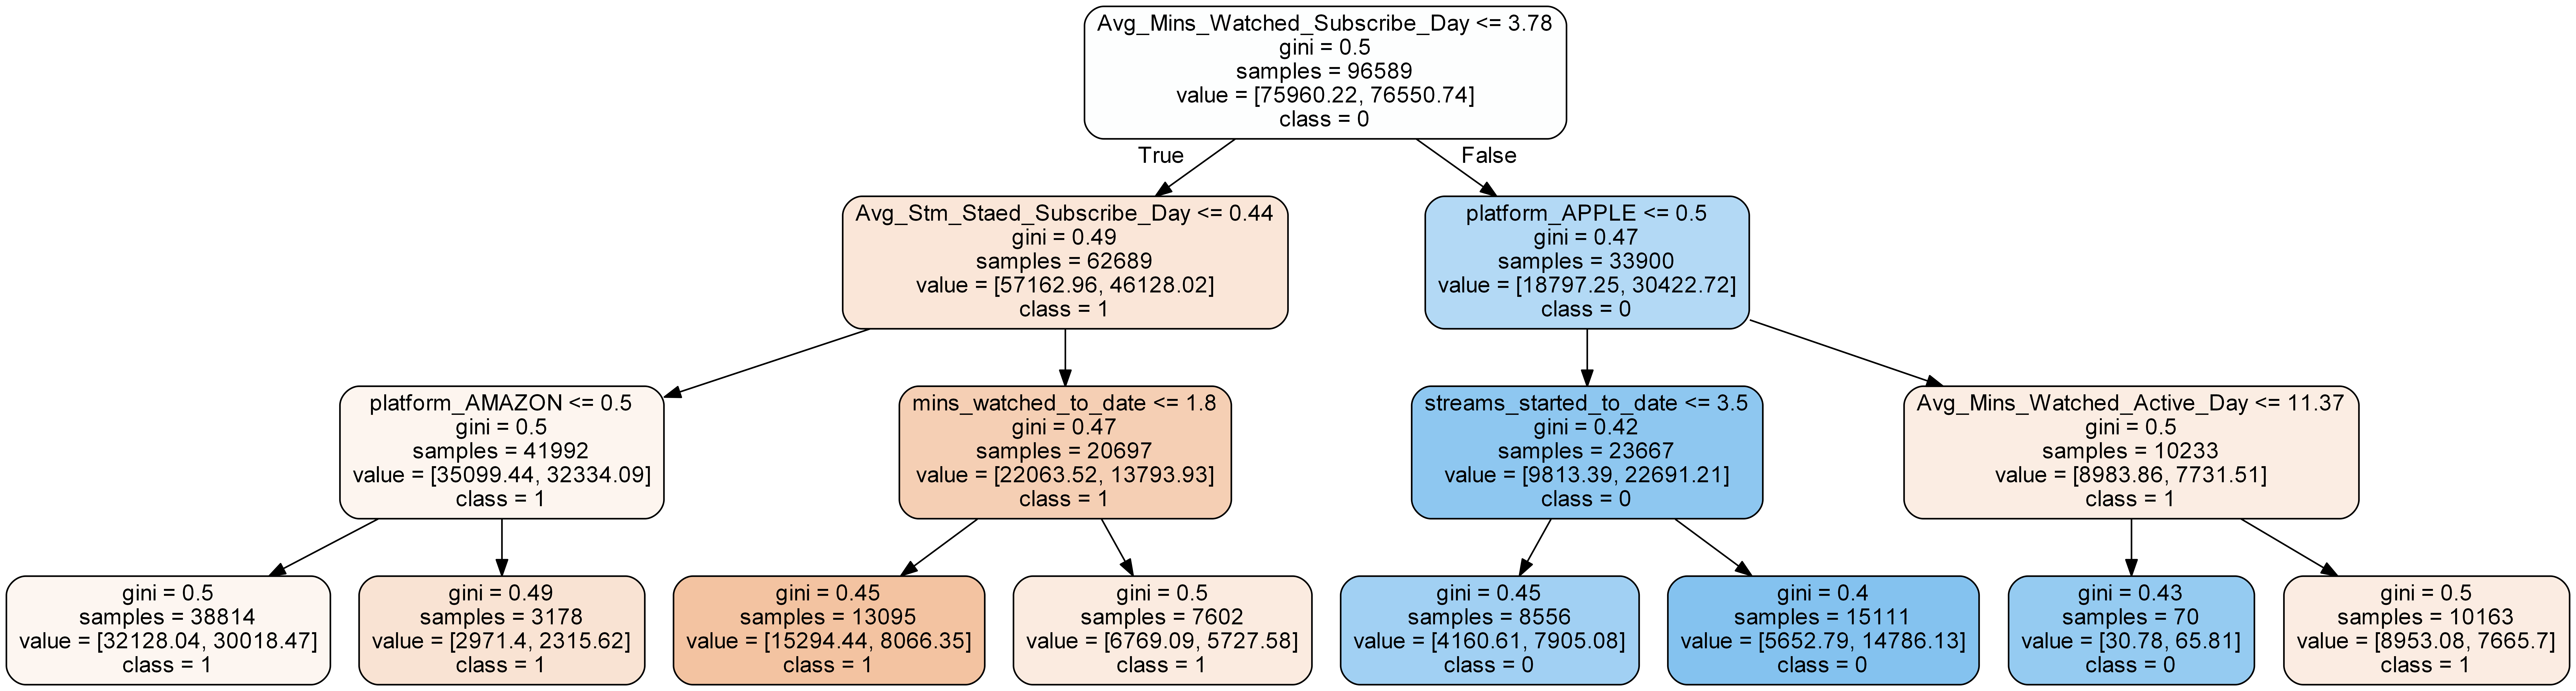

In [ ]:
# draw the tree
Image(filename = 'tree.png')

### Model Diagnostic:

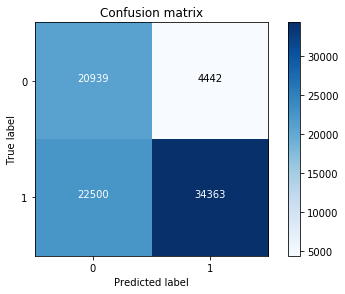

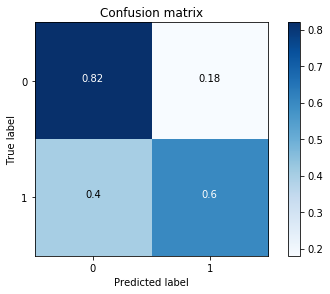

In [ ]:
# Confusion Matrix:
confusion= confusion_matrix(y_test, forest_predict)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(confusion, normalize=False , classes=class_names, title='Confusion matrix')
plt.show()
# Build normalization matrix using the counts in test data for each category
norm_matrix=np.array([[1/y_test_leg, 1/y_test_leg], [1/y_test_fra, 1/y_test_fra]])
# normalize the unbalanced regular confusion matrix， each row sums up to 1
confusion_norm = np.around(confusion*norm_matrix, 2)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(confusion_norm, normalize=False , classes=class_names, title='Confusion matrix')
plt.show()

In [ ]:
# Classificatoin report of the test data
print("Classification report with training data")
print(classification_report(y_test, forest_predict))

Classification report with training data
             precision    recall  f1-score   support

          0       0.48      0.82      0.61     25381
          1       0.89      0.60      0.72     56863

avg / total       0.76      0.67      0.68     82244



### Conclusion and Recommendation:
1. The model successfully recognized 82% of the customers who did not convert to paid users in the test data
2. After identifying these customers, marketing can come up with retention strategies to help these customers convert
3. The model also reveals that users signed up from certain platforms (e.g. BAMTECH) are more likely to convert than users signed up from other platofrms
4. Given limited time, there are more opportunities in this case we can further improve this model